**Note:** The spectrogram conversion code is taken from riffusion and edited to have a minimal working example. All the parameters were left as in the original riffusion code.

In [1]:
import pydub
import typing as T
from dataclasses import dataclass
from enum import Enum

@dataclass(frozen=True)
class SpectrogramParams:

    # Whether the audio is stereo or mono
    stereo: bool = False

    # FFT parameters
    sample_rate: int = 44100
    step_size_ms: int = 10
    window_duration_ms: int = 100
    padded_duration_ms: int = 400

    # Mel scale parameters
    num_frequencies: int = 512
    min_frequency: int = 0
    max_frequency: int = 10000  # TODO (Ema): probably better to use 20 to 20,000
    mel_scale_norm: T.Optional[str] = None
    mel_scale_type: str = "htk"

    # Griffin Lim parameters
    num_griffin_lim_iters: int = 32

    # Image parameterization
    power_for_image: float = 0.25

    @property
    def n_fft(self) -> int:
        """
        The number of samples in each STFT window, with padding.
        """
        return int(self.padded_duration_ms / 1000.0 * self.sample_rate)

    @property
    def win_length(self) -> int:
        """
        The number of samples in each STFT window.
        """
        return int(self.window_duration_ms / 1000.0 * self.sample_rate)

    @property
    def hop_length(self) -> int:
        """
        The number of samples between each STFT window.
        """
        return int(self.step_size_ms / 1000.0 * self.sample_rate)

In [2]:
import io
import numpy as np
from scipy.io import wavfile

def audio_from_waveform(
    samples: np.ndarray, sample_rate: int, normalize: bool = False
) -> pydub.AudioSegment:
    """
    Convert a numpy array of samples of a waveform to an audio segment.

    Args:
        samples: (channels, samples) array
    """
    # Normalize volume to fit in int16
    if normalize:
        samples *= np.iinfo(np.int16).max / np.max(np.abs(samples))

    # Transpose and convert to int16
    samples = samples.transpose(1, 0)
    samples = samples.astype(np.int16)

    # Write to the bytes of a WAV file
    wav_bytes = io.BytesIO()
    wavfile.write(wav_bytes, sample_rate, samples)
    wav_bytes.seek(0)

    # Read into pydub
    return pydub.AudioSegment.from_wav(wav_bytes)

def apply_filters(segment: pydub.AudioSegment, compression: bool = False) -> pydub.AudioSegment:
    """
    Apply post-processing filters to the audio segment to compress it and
    keep at a -10 dBFS level.
    """

    if compression:
        segment = pydub.effects.normalize(
            segment,
            headroom=0.1,
        )

        segment = segment.apply_gain(-10 - segment.dBFS)

        segment = pydub.effects.compress_dynamic_range(
            segment,
            threshold=-20.0,
            ratio=4.0,
            attack=5.0,
            release=50.0,
        )

    desired_db = -12
    segment = segment.apply_gain(desired_db - segment.dBFS)

    segment = pydub.effects.normalize(
        segment,
        headroom=0.1,
    )

    return segment

In [3]:
import numpy as np
import pydub
import torch
import torchaudio

class SpectrogramConverter:
    """
    Convert between audio segments and spectrogram tensors using torchaudio.

    In this class a "spectrogram" is defined as a (batch, time, frequency) tensor with float values
    that represent the amplitude of the frequency at that time bucket (in the frequency domain).
    Frequencies are given in the perceptul Mel scale defined by the params. A more specific term
    used in some functions is "mel amplitudes".

    The spectrogram computed from `spectrogram_from_audio` is complex valued, but it only
    returns the amplitude, because the phase is chaotic and hard to learn. The function
    `audio_from_spectrogram` is an approximate inverse of `spectrogram_from_audio`, which
    approximates the phase information using the Griffin-Lim algorithm.

    Each channel in the audio is treated independently, and the spectrogram has a batch dimension
    equal to the number of channels in the input audio segment.

    Both the Griffin Lim algorithm and the Mel scaling process are lossy.

    For more information, see https://pytorch.org/audio/stable/transforms.html
    """

    def __init__(self, params: SpectrogramParams, device: str = "cuda"):
        self.p = params

        self.device = device

        if device.lower().startswith("mps"):
            warnings.warn(
                "WARNING: MPS does not support audio operations, falling back to CPU for them",
                stacklevel=2,
            )
            self.device = "cpu"

        # https://pytorch.org/audio/stable/generated/torchaudio.transforms.Spectrogram.html
        self.spectrogram_func = torchaudio.transforms.Spectrogram(
            n_fft=params.n_fft,
            hop_length=params.hop_length,
            win_length=params.win_length,
            pad=0,
            window_fn=torch.hann_window,
            power=None,
            normalized=False,
            wkwargs=None,
            center=True,
            pad_mode="reflect",
            onesided=True,
        ).to(self.device)

        # https://pytorch.org/audio/stable/generated/torchaudio.transforms.GriffinLim.html
        self.inverse_spectrogram_func = torchaudio.transforms.GriffinLim(
            n_fft=params.n_fft,
            n_iter=params.num_griffin_lim_iters,
            win_length=params.win_length,
            hop_length=params.hop_length,
            window_fn=torch.hann_window,
            power=1.0,
            wkwargs=None,
            momentum=0.99,
            length=None,
            rand_init=True,
        ).to(self.device)

        # https://pytorch.org/audio/stable/generated/torchaudio.transforms.MelScale.html
        self.mel_scaler = torchaudio.transforms.MelScale(
            n_mels=params.num_frequencies,
            sample_rate=params.sample_rate,
            f_min=params.min_frequency,
            f_max=params.max_frequency,
            n_stft=params.n_fft // 2 + 1,
            norm=params.mel_scale_norm,
            mel_scale=params.mel_scale_type,
        ).to(self.device)

        # https://pytorch.org/audio/stable/generated/torchaudio.transforms.InverseMelScale.html
        self.inverse_mel_scaler = torchaudio.transforms.InverseMelScale(
            n_stft=params.n_fft // 2 + 1,
            n_mels=params.num_frequencies,
            sample_rate=params.sample_rate,
            f_min=params.min_frequency,
            f_max=params.max_frequency,
            norm=params.mel_scale_norm,
            mel_scale=params.mel_scale_type,
        ).to(self.device)

    def spectrogram_from_audio(
        self,
        audio: pydub.AudioSegment,
    ) -> np.ndarray:
        """
        Compute a spectrogram from an audio segment.

        Args:
            audio: Audio segment which must match the sample rate of the params

        Returns:
            spectrogram: (channel, frequency, time)
        """
        assert int(audio.frame_rate) == self.p.sample_rate, "Audio sample rate must match params"

        # Get the samples as a numpy array in (batch, samples) shape
        waveform = np.array([c.get_array_of_samples() for c in audio.split_to_mono()])

        # Convert to floats if necessary
        if waveform.dtype != np.float32:
            waveform = waveform.astype(np.float32)

        waveform_tensor = torch.from_numpy(waveform).to(self.device)
        amplitudes_mel = self.mel_amplitudes_from_waveform(waveform_tensor)
        return amplitudes_mel.cpu().numpy()

    def audio_from_spectrogram(
        self,
        spectrogram: np.ndarray,
        do_apply_filters: bool = True,
    ) -> pydub.AudioSegment:
        """
        Reconstruct an audio segment from a spectrogram.

        Args:
            spectrogram: (batch, frequency, time)
            apply_filters: Post-process with normalization and compression

        Returns:
            audio: Audio segment with channels equal to the batch dimension
        """

        print("Converting... ", end='', flush=True)

        # Move to device
        amplitudes_mel = torch.from_numpy(spectrogram).to(self.device)

        # Reconstruct the waveform
        waveform = self.waveform_from_mel_amplitudes(amplitudes_mel)

        # Convert to audio segment
        segment = audio_from_waveform(
            samples=waveform.cpu().numpy(),
            sample_rate=self.p.sample_rate,
            # Normalize the waveform to the range [-1, 1]
            normalize=True,
        )

        # Optionally apply post-processing filters
        if do_apply_filters:
            segment = apply_filters(
                segment,
                compression=False,
            )

        print("done.")

        return segment

    def mel_amplitudes_from_waveform(
        self,
        waveform: torch.Tensor,
    ) -> torch.Tensor:
        """
        Torch-only function to compute Mel-scale amplitudes from a waveform.

        Args:
            waveform: (batch, samples)

        Returns:
            amplitudes_mel: (batch, frequency, time)
        """
        # Compute the complex-valued spectrogram
        spectrogram_complex = self.spectrogram_func(waveform)

        # Take the magnitude
        amplitudes = torch.abs(spectrogram_complex)

        # Convert to mel scale
        return self.mel_scaler(amplitudes)

    def waveform_from_mel_amplitudes(
        self,
        amplitudes_mel: torch.Tensor,
    ) -> torch.Tensor:
        """
        Torch-only function to approximately reconstruct a waveform from Mel-scale amplitudes.

        Args:
            amplitudes_mel: (batch, frequency, time)

        Returns:
            waveform: (batch, samples)
        """
        # Convert from mel scale to linear
        amplitudes_linear = self.inverse_mel_scaler(amplitudes_mel)

        # Run the approximate algorithm to compute the phase and recover the waveform
        return self.inverse_spectrogram_func(amplitudes_linear)


In [4]:
device = "cuda"

# audio_path = '../../modgen/cool/cool_arpeggio.mp3'
audio_path = '../../modgen/potter/0010.wav'

segment = pydub.AudioSegment.from_file(audio_path).set_channels(1)

param_sets: T.Dict[str, SpectrogramParams] = {}

param_sets["default"] = SpectrogramParams(
            sample_rate=44100,
            stereo=False,
            step_size_ms=10,
            min_frequency=20,
            max_frequency=20000,
            num_frequencies=512,
        )

segments: T.Dict[str, pydub.AudioSegment] = {
            "original": segment,
        }

# run tests over different sets of params
for name, params in param_sets.items():
    
    segment = pydub.AudioSegment.from_file(audio_path).set_channels(1).set_frame_rate(params.sample_rate)
    converter = SpectrogramConverter(params=params, device=device)
    spectrogram = converter.spectrogram_from_audio(segment)
    segments[name] = converter.audio_from_spectrogram(spectrogram, do_apply_filters=False)

Converting... done.


Stretching happens here:

In [5]:
import PIL.Image

spec_original = spectrogram.squeeze()

# compress to half duration
# target_sz = int(spec_original.shape[1]*0.5)

# stretch to double duration
target_sz = spec_original.shape[1] * 2

spec_interp_nearest = np.asarray(PIL.Image.fromarray(spec_original).resize((target_sz, 512), PIL.Image.NEAREST))
spec_interp_bilinear = np.asarray(PIL.Image.fromarray(spec_original).resize((target_sz, 512), PIL.Image.BILINEAR))
spec_interp_bicubic = np.asarray(PIL.Image.fromarray(spec_original).resize((target_sz, 512), PIL.Image.BICUBIC))
spec_interp_lanczos = np.asarray(PIL.Image.fromarray(spec_original).resize((target_sz, 512), PIL.Image.LANCZOS))

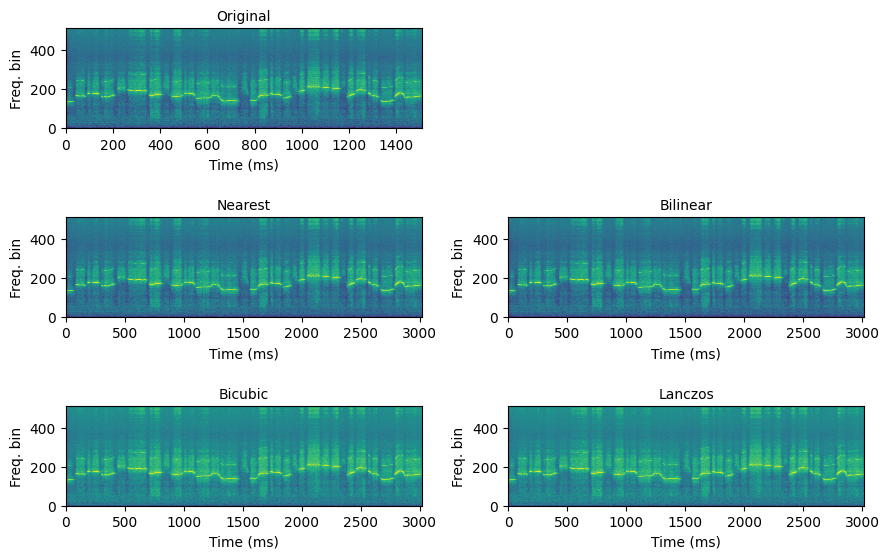

In [6]:
import matplotlib.pyplot as plt
import librosa

plt.figure(figsize=(9,6))

plt.subplot(321)
plt.imshow(librosa.power_to_db(spec_original), origin='lower', aspect='auto', interpolation="nearest")
plt.ylabel('Freq. bin')
plt.xlabel('Time (ms)')
plt.title('Original', fontsize=10)

plt.subplot(323)
plt.imshow(librosa.power_to_db(spec_interp_nearest), origin='lower', aspect='auto', interpolation="nearest")
plt.ylabel('Freq. bin')
plt.xlabel('Time (ms)')
plt.title('Nearest', fontsize=10)

plt.subplot(324)
plt.imshow(librosa.power_to_db(spec_interp_bilinear), origin='lower', aspect='auto', interpolation="nearest")
plt.ylabel('Freq. bin')
plt.xlabel('Time (ms)')
plt.title('Bilinear', fontsize=10)

plt.subplot(325)
plt.imshow(librosa.power_to_db(spec_interp_bicubic), origin='lower', aspect='auto', interpolation="nearest")
plt.ylabel('Freq. bin')
plt.xlabel('Time (ms)')
plt.title('Bicubic', fontsize=10)

plt.subplot(326)
plt.imshow(librosa.power_to_db(spec_interp_lanczos), origin='lower', aspect='auto', interpolation="nearest")
plt.ylabel('Freq. bin')
plt.xlabel('Time (ms)')
plt.title('Lanczos', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.9)

plt.show()

Convert back to time domain. 

From my quick tests, I think that using costly bicubic or Lanczos interpolation is not worth the effort. Nearest neighbor seems good enough already.

In [7]:
audio_original = converter.audio_from_spectrogram(spec_original[None, :], do_apply_filters=False)

audio_interp_nearest = converter.audio_from_spectrogram(spec_interp_nearest[None, :], do_apply_filters=False)
audio_interp_bilinear = converter.audio_from_spectrogram(spec_interp_bilinear[None, :], do_apply_filters=False)
audio_interp_bicubic = converter.audio_from_spectrogram(spec_interp_bicubic[None, :], do_apply_filters=False)
audio_interp_lanczos = converter.audio_from_spectrogram(spec_interp_lanczos[None, :], do_apply_filters=False)

Converting... done.
Converting... 

C:\Users\erodo\AppData\Local\Temp\ipykernel_32568\30732785.py:136: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  amplitudes_mel = torch.from_numpy(spectrogram).to(self.device)


done.
Converting... done.
Converting... done.
Converting... done.


In [8]:
audio_original

In [9]:
audio_interp_nearest

In [10]:
audio_interp_bilinear

In [11]:
audio_interp_bicubic

In [12]:
audio_interp_lanczos